# Boosting (XGBoost, LightGBM, CatBoost)

In [141]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns

## Feature Engineering

In [142]:
data_train = pd.read_csv('./data/titanic_train.csv')

In [143]:
data_test = pd.read_csv('./data/titanic_test.csv')

In [144]:
nan_values = data_train.isna()
nan_columns = nan_values.any()
nan_columns

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [145]:
nan_values_test = data_test.isna()
nan_columns_test = nan_values_test.any()
nan_columns_test

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [146]:
age_avg = data_train['Age'].mean()
data_train['Age'] = data_train['Age'].fillna(age_avg)
data_train['family_s'] = data_train['SibSp'] + data_train['Parch'] + 1
age_avg = data_test['Age'].mean()
data_test['family_s'] = data_test['SibSp'] + data_test['Parch'] + 1
data_test[['Age']] = data_test[['Age']].fillna(age_avg)

In [147]:
import jenkspy
from jenkspy import JenksNaturalBreaks
jnb = JenksNaturalBreaks()
jnb.fit(data_train['Age'])
try:
    print(jnb.labels_)
    print(jnb.groups_)
    print(jnb.inner_breaks_)
except:
    pass

[1 3 2 3 3 2 4 0 2 1 0 5 1 3 1 4 0 2 2 2 3 3 1 2 0 3 2 1 2 2 3 2 2 5 2 3 2
 1 1 1 3 2 2 0 1 2 2 2 2 1 0 1 4 2 5 2 1 2 0 0 1 3 4 0 2 2 2 1 1 2 2 1 1 2
 2 2 2 2 0 2 1 2 2 2 1 2 1 2 1 1 2 1 4 2 5 2 5 1 3 3 2 2 1 2 3 2 1 2 3 2 4
 1 1 1 1 1 5 2 1 0 1 2 2 2 4 0 2 1 2 4 2 1 4 2 2 1 1 3 1 1 2 1 1 1 1 1 2 0
 3 3 4 1 4 3 2 4 1 2 2 2 4 3 2 1 0 0 2 4 2 2 5 0 0 1 5 1 2 4 2 3 2 2 0 0 0
 2 2 4 3 3 2 1 1 0 4 5 2 3 2 1 2 2 3 4 1 0 2 2 1 3 1 3 1 2 2 2 2 3 2 2 1 2
 4 2 3 1 1 1 1 2 3 2 5 0 1 2 4 0 1 2 2 2 2 1 2 4 2 1 3 4 2 2 5 2 3 2 2 2 3
 4 2 0 4 3 2 3 1 2 5 3 2 2 3 3 2 5 4 2 0 3 5 2 1 1 2 2 2 1 3 1 2 1 3 1 1 2
 1 0 2 4 2 2 1 2 2 0 2 1 2 2 1 1 2 2 3 2 1 4 2 3 1 2 2 1 2 3 5 3 2 1 2 4 3
 1 2 2 2 3 4 4 0 1 2 2 3 1 3 2 0 3 1 2 1 2 2 2 1 3 2 2 3 2 4 3 2 2 5 2 2 1
 2 1 1 1 0 2 1 2 1 1 3 0 2 3 2 1 0 3 2 1 3 1 2 1 1 1 2 4 1 2 3 2 1 2 1 3 4
 0 1 2 2 2 2 2 4 2 3 1 2 0 2 1 2 2 1 2 2 1 2 2 2 2 3 1 4 1 1 1 5 2 4 1 2 2
 2 0 1 3 0 4 3 2 2 4 2 2 5 2 4 2 4 3 4 4 2 3 2 5 2 0 2 3 2 1 1 2 3 2 1 0 0
 2 4 5 2 2 3 5 2 0 2 1 4 

In [148]:
len(jnb.groups_)

6

In [149]:
data_train['Age']

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64

In [150]:
#https://towardsdatascience.com/binning-records-on-a-continuous-variable-with-pandas-cut-and-qcut-5d7c8e11d7b0
# QCut or “quantile cut” splits based on the number of examples falling into each bucket
data_train['Age'] = pd.qcut(data_train['Age'], 6, duplicates='drop')
data_test['Age'] = pd.qcut(data_test['Age'], 6, duplicates='drop')

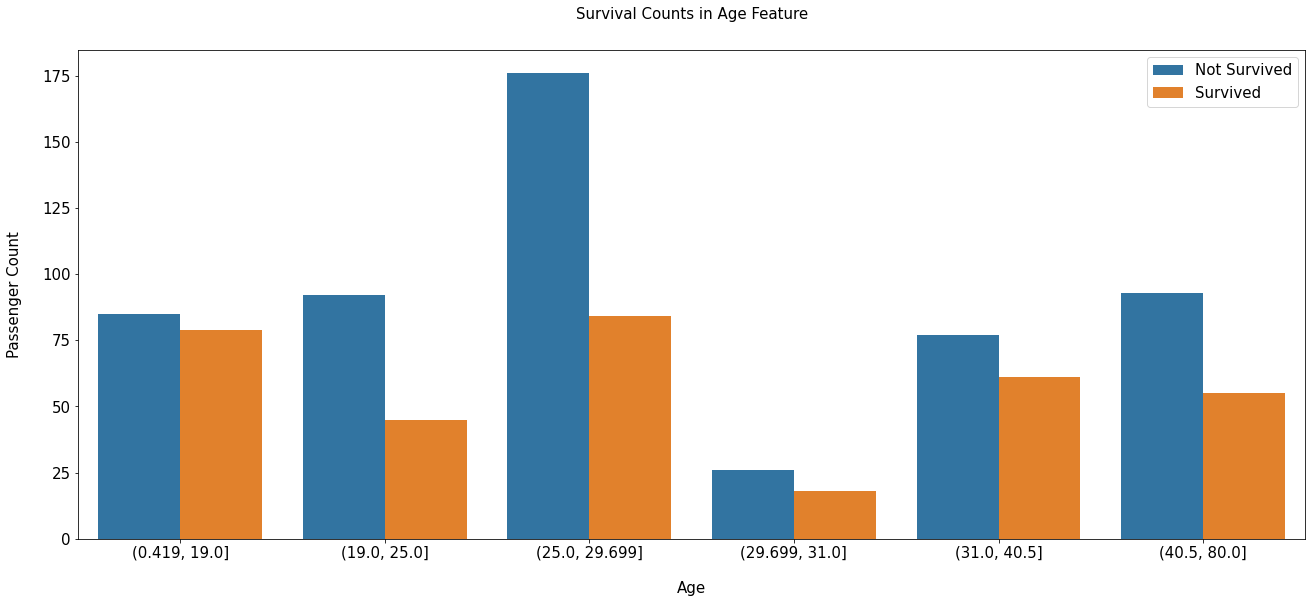

In [151]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=data_train)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [152]:
data_train[data_train.Embarked.isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_s
61,62,1,1,"Icard, Miss. Amelie",female,"(31.0, 40.5]",0,0,113572,80.0,B28,NaN,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,"(40.5, 80.0]",0,0,113572,80.0,B28,NaN,1


https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html
Both boarded in Southampton

In [153]:
data_train['Embarked'] = data_train['Embarked'].fillna('S')

In [154]:
fare_avg = data_test['Fare'].mean()
data_test[['Fare']] = data_test[['Fare']].fillna(fare_avg)

In [155]:
data_train['ticket_group_count'] = data_train.groupby('Ticket')['Ticket'].transform('count')

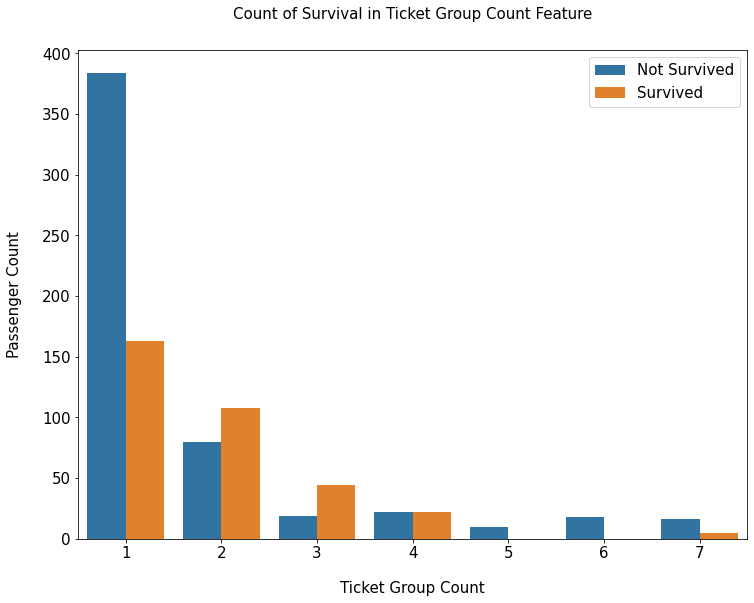

In [156]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='ticket_group_count', hue='Survived', data=data_train)

plt.xlabel('Ticket Group Count', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Group Count'), size=15, y=1.05)

plt.show()

Gropus of peaople have higher survival rate. (we checked passangers with the same tickets). It can be our additional feature

In [157]:
data_test['ticket_group_count'] = data_test.groupby('Ticket')['Ticket'].transform('count')

In [158]:
data_train.drop(columns=['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1, inplace=True)

y_cat = y = data_train.Survived.reset_index(drop=True)

In [159]:
data_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'family_s', 'ticket_group_count'],
      dtype='object')

In [160]:
data_train.dtypes

Survived                 int64
Pclass                   int64
Sex                     object
Age                   category
SibSp                    int64
Parch                    int64
Fare                   float64
Embarked                object
family_s                 int64
ticket_group_count       int64
dtype: object

In [161]:
features = data_train.columns[1:]
features

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'family_s', 'ticket_group_count'],
      dtype='object')

In [162]:
categorical_features = ['Sex', 'Pclass', 'Embarked']
ct = make_column_transformer(
        (OneHotEncoder(), categorical_features),
        remainder='passthrough', verbose_feature_names_out=True)
data_transformed = ct.fit_transform(data_train.iloc[:, 1:], y=data_train.Survived)
X = pd.DataFrame(data_transformed, columns=ct.get_feature_names_out())
X = X.astype({"onehotencoder__Sex_female": int,
              "onehotencoder__Sex_male": int,
             "onehotencoder__Pclass_1": int,
             "onehotencoder__Pclass_2": int,
             "onehotencoder__Pclass_3": int,
             "onehotencoder__Embarked_C": int,
             "onehotencoder__Embarked_Q": int,
             "onehotencoder__Embarked_S": int,
             "remainder__SibSp":int,
             "remainder__Parch": int,
             "remainder__Fare": float,
             "remainder__family_s": int,
             "remainder__ticket_group_count" : int})
X["remainder__Age"] = LabelEncoder().fit_transform(X["remainder__Age"])
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
X.dtypes

onehotencoder__Sex_female          int64
onehotencoder__Sex_male            int64
onehotencoder__Pclass_1            int64
onehotencoder__Pclass_2            int64
onehotencoder__Pclass_3            int64
onehotencoder__Embarked_C          int64
onehotencoder__Embarked_Q          int64
onehotencoder__Embarked_S          int64
remainder__Age                     int64
remainder__SibSp                   int64
remainder__Parch                   int64
remainder__Fare                  float64
remainder__family_s                int64
remainder__ticket_group_count      int64
dtype: object

In [165]:
PassengerId = data_test['PassengerId']
test_transformed = ct.fit_transform(data_test[features])
test_transformed = pd.DataFrame(test_transformed, columns=ct.get_feature_names_out())
test_transformed = test_transformed.astype({"onehotencoder__Sex_female": int,
              "onehotencoder__Sex_male": int,
             "onehotencoder__Pclass_1": int,
             "onehotencoder__Pclass_2": int,
             "onehotencoder__Pclass_3": int,
             "onehotencoder__Embarked_C": int,
             "onehotencoder__Embarked_Q": int,
             "onehotencoder__Embarked_S": int,
             "remainder__SibSp":int,
             "remainder__Parch": int,
             "remainder__Fare": float,
             "remainder__family_s": int,
             "remainder__ticket_group_count" : int,
                })
test_transformed["remainder__Age"]= LabelEncoder().fit_transform(test_transformed["remainder__Age"])
test_transformed.dtypes

onehotencoder__Sex_female          int64
onehotencoder__Sex_male            int64
onehotencoder__Pclass_1            int64
onehotencoder__Pclass_2            int64
onehotencoder__Pclass_3            int64
onehotencoder__Embarked_C          int64
onehotencoder__Embarked_Q          int64
onehotencoder__Embarked_S          int64
remainder__Age                     int64
remainder__SibSp                   int64
remainder__Parch                   int64
remainder__Fare                  float64
remainder__family_s                int64
remainder__ticket_group_count      int64
dtype: object

In [19]:
X_cat = data
X_cat.drop('Survived', inplace=True, axis=1)
X_cat['Sex'].replace(['male','female'], [0, 1], inplace=True)
X_cat['Embarked'].replace(['C','Q', 'S'], [0, 1, 2], inplace=True)
X_cat = X_cat.astype(np.float64)
X_cat = X_cat.astype({"Sex": int, "Pclass": int, "SibSp": int, 'Parch': int, 'Embarked':int})
X_cat.dtypes

NameError: name 'data' is not defined

In [20]:
test_transformed_categorical = test
test_transformed_categorical['Sex'].replace(['male','female'], [0, 1], inplace=True)
test_transformed_categorical['Embarked'].replace(['C','Q', 'S'], [0, 1, 2], inplace=True)
test_transformed_categorical = test_transformed_categorical[features]
test_transformed_categorical.dtypes

NameError: name 'test' is not defined

In [503]:
X_cat.dtypes

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Embarked      int64
dtype: object

In [504]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.8161764705882353, 1: 1.2906976744186047}

# Xgboost



### Boosting settings

**Explanation after lightgbm theory**<br>
`tree_method` – 'exact' (if you have time, you can try), 'approx', 'hist'(the best choise usually) <br>
`grow_policy` – 'depthwise', 'lossguide' (usually better)<br>
`objective` – default is quite good (sometimes "count:poisson")


### XGBoost parameters tuning

Usually we start tuning parameters with these first: <br>
`n_estimators` - number of boosting rounds, better to use `early_stopping_rounds` <br>
`eta` – learning rate, increasing lr reduces convergence time. (usually default value works good)

### Control Overfitting
When you observe high training accuracy, but low tests accuracy, it is likely that you encounter overfitting problem.

There are in general two ways that you can control overfitting:

* The first way is to directly control model complexity <p>
`max_depth` - maximum depth of a tree, increase of this value will make the model more complex; <br>
`gamma` - minimum loss reduction required to make a further partition on a leaf node of the tree.<br>
`min_child_weight` – minimum sum of instance weight (hessian) needed in a child.


* The second way is to add randomness to make training robust to noise <p>
`subsample` - subsample ratio of the training instance, <br>
`colsample_bytree` - subsample ratio of columns when constructing each tree. <br>


### Handle Imbalanced Dataset
There are two ways to improve it:

* If you care only about the ranking order (AUC) of your prediction
Balance the positive and negative weights, via `scale_pos_weight`
Use AUC for evaluation
* If you care about predicting the right probability
In such a case, you cannot re-balance the dataset. Set parameter `max_delta_step` to a finite number (say 1) will help to converge <br>

More about xgboost parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Always use `early_stopping_round` and tune `n_estimators` on validation.

In [166]:
import xgboost as xgb


parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 4,
    "random_seed": 1,
    "eval_metric": "error"
}


xgb_train = xgb.DMatrix(X, y, feature_names=X.columns)
xgb_test = xgb.DMatrix(test_transformed)

# 0.78229
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 10,
    "random_seed": 1,
    "eval_metric": "error",
    
    # regularization parameters
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "colsample_bylevel":0.8,
    "colsample_bynode":0.7,
    "alpha": 4,
    "max_leaves": 14,

    
    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}

In [182]:
# 0.78229
parameters = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 10,
    "random_seed": 1,
    "eval_metric": "error",
    
    # regularization parameters
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "colsample_bylevel":0.8,
    "colsample_bynode":0.7,
    "alpha": 4,
    "max_leaves": 14,

    
    #lightgbm approach
    "tree_method": "hist",
    "grow_policy": "lossguide"
}
num_rounds = 500
results = xgb.cv(parameters, xgb_train, num_rounds, early_stopping_rounds=50,
                 folds=skf, verbose_eval=100)

[0]	train-error:0.18519+0.01074	test-error:0.20090+0.01871
[88]	train-error:0.16835+0.00630	test-error:0.18967+0.01270


In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
xgb_model = xgb.XGBClassifier(objective = "binary:logistic")
params = {
            'min_child_weight': np.arange(1, 5, 0.5).tolist(),
            'subsample': np.arange(0.5, 1.0, 0.1).tolist(),
            'colsample_bytree': np.arange(0.5, 1.0, 0.1).tolist(),
            "colsample_bylevel":np.arange(0.5, 1.0, 0.1).tolist(),
            "colsample_bynode":np.arange(0.5, 1.0, 0.1).tolist(),
            "alpha": np.arange(1, 7, 1).tolist(),
            "max_leaves": np.arange(5, 15, 1).tolist(),    
        }
grid = GridSearchCV(xgb_model, 
                    param_grid = params, 
                    n_jobs = -1, 
                    cv = skf.split(X, y),
                    refit = "accuracy_score")

grid.fit(X, y)

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

[18:11:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:11:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:11:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:11:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:13:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

[19:27:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[19:27:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[19:28:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:30:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:32:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:35:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[19:27:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:29:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:31:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:34:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

[20:34:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:39:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:33:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:39:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:34:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:39:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[20:34:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:37:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:39:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/xgboost

KeyboardInterrupt: 

In [ ]:
best_pars = grid.best_params_

In [175]:
parameters['n_estimators'] = 54
clf = xgb.XGBClassifier(**parameters, use_label_encoder=False)
bst = clf.fit(X, y)

In [176]:
parameters

{'objective': 'binary:logistic',
 'eta': 0.1,
 'verbosity': 0,
 'nthread': 10,
 'random_seed': 1,
 'eval_metric': 'error',
 'max_depth': 7,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'colsample_bylevel': 0.8,
 'colsample_bynode': 0.7,
 'alpha': 6,
 'max_leaves': 14,
 'tree_method': 'hist',
 'grow_policy': 'lossguide',
 'n_estimators': 54}

In [177]:
y_077990 = pd.read_csv('submission_xgboost_077990.csv')

In [178]:
bst.best_iteration

53

In [179]:
y_077990

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [180]:
y_pred = bst.predict(test_transformed)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission_xgboost.csv', index=False)
(submission == y_077990).all()

PassengerId     True
Survived       False
dtype: bool

### Some useful notes

1. Custom objective and evaluation functions – https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
2. Never use timeseries validation with **xgb.cv**, it is broken :( 
3. Investigate your task and metrics. There are many objective functions that are worth to try.


# LightGBM

### Lightgbm Parameters Tunning


**Core parameters**

Begin with `learning_rate` parameter setting with default value <br>
`n_estimators`(number of boosting iterations) set 10k (some big number).<br>
`num_leaves` (number of leaves in one tree) set 155 as a starting point.<br>
`objective` –  the same as for xgboost `objective` (adding "regression_l1")

**Control Overfitting and Accuracy**

`max_depth` – max tree depth (`default=-1`). Start with tunning `num_leaves`, in the end try to change `max_depth`; <br>
`min_data_in_leaf` – very important parameter that helps to control overfitting (`default=20`);<br>
`colsample_bytree` – select part of features on each iteration (`default=1.0`). Always have to be tunned! <br>
`subsample` – select part of data without resampling (`default=1.0`). To enable it, set `subsample_freq` = 1 (other values always work worse)
`early_stopping_round` – as in xgboost



In [532]:
import lightgbm as lgb
from lightgbm.callback import log_evaluation, early_stopping
callbacks = [log_evaluation(50), early_stopping(100)]
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42
}
n_rounds = 1000

lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)

In [533]:
result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=False)

[LightGBM] [Info] Number of positive: 226, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0023

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [534]:
parameters = {
    #default
    "objective": "binary",
    "learning_rate": 0.01,
    "num_threads": 10,
    "metric": 'binary_error',
    "seed": 42,
    
    #regularization
    "colsample_bytree": 0.8,
    "subsample": 0.9, 
    "subsample_freq": 1,
    "colsample_bytree": 0.8, 
}
result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=False)

[LightGBM] [Info] Number of positive: 226, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0023

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [535]:
parameters = {
    #default
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42,
    
    #regularization
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "min_data_in_leaf": 10,
}

result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=False)

[LightGBM] [Info] Number of positive: 226, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0010

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [536]:
callbacks = [log_evaluation(50), early_stopping(100)]
parameters = {
    #default
    "objective": "binary",
    "learning_rate": 0.05,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42,
    
    #regularization
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "subsample_freq": 1,
    "min_data_in_leaf": 10,
}


result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=True)

[LightGBM] [Info] Number of positive: 226, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0008

In [537]:
# 0.78229

parameters = {
    #default
    "n_estimators": 400,
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42,
    "max_depth": 7,
    "num_leaves": 8,
    #regularization
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "colsample_bynode":0.7,
    "subsample_freq": 1,
    "min_data_in_leaf": 20,
}


result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=True)

[LightGBM] [Info] Number of positive: 226, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 593, number of used features: 11
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.0012

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	cv_agg's train binary_error: 0.14454 + 0.00562693	cv_agg's valid binary_error: 0.182213 + 0.0124073
[100]	cv_agg's train binary_error: 0.133291 + 0.0062159	cv_agg's valid binary_error: 0.191214 + 0.00942462
Early stopping, best iteration is:
[17]	cv_agg's train binary_error: 0.16535 + 0.00619184	cv_agg's valid binary_error: 0.173219 + 0.0202439


0.74880
parameters = {
    #default
    "n_estimators": 300,
    "objective": "binary",
    "learning_rate": 0.05,
    "num_threads": 10,
    "metric": "auc",
    "seed": 42,
    "max_depth":3,
    "num_leaves": 7,
    "max_bin": 512,
    "subsample_for_bin": 200,
    #regularization
    "colsample_bytree": 0.5,
    "subsample": 1,
    "subsample_freq": 1,
    "min_data_in_leaf": 10,
    "scale_pos_weight": scale_pos_weight
}


result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=True)

In [538]:
parameters = {
    #default
    "n_estimators": 400,
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 10,
    "metric": "binary_error",
    "seed": 42,
    "max_depth": 7,
    "num_leaves": 8,
    #regularization
    "subsample": 0.8,
    "colsample_bytree": 0.6,
    "colsample_bylevel":0.6,
    "colsample_bynode":0.7,
    "subsample_freq": 1,
    "min_data_in_leaf": 20,
    #categorical features
    'cat_smooth': 1,
    'min_data_per_group': 50
}
lgb_train = lgb.Dataset(X_cat, label=y, free_raw_data=False, categorical_feature=['Sex', 'Pclass', 'Embarked'])
result = lgb.cv(parameters, lgb_train, n_rounds, folds=skf, callbacks=callbacks, eval_train_metric=True)

/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Info] Number of positive: 226, number of negative: 366
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 6
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Info] Number of positive: 227, number of negative: 366
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[L

In [539]:
parameters['n_estimators'] = 17
lgbc = lgb.LGBMClassifier(**parameters)
lgbf = lgbc.fit(X_cat,y,categorical_feature=['Sex', 'Pclass', 'Embarked'])

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/i.kozlov/venv/mlcourse/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


In [540]:
print(lgbf.best_iteration_)

None


In [541]:
y_pred_l = lgbf.predict(test_transformed_categorical, categorical_feature=['Sex', 'Pclass', 'Embarked'])
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred_l
    })
submission.to_csv('submission_lightgbm.csv', index=False)

# CatBoost

### CatBoost parameters tunning

**`loss_function`** – The metric to use in training (the same as objective in xgb/lgb)<br>
**`eval_metric`** – The metric used for overfitting detection (if enabled) and the best model selection (if enabled).<br>
**`iterations`** – The maximum number of trees<br>
**`learning_rate`** – Learing rate :) (default 0.03)<br>
**`random_seed`** – is not set by default. always set to reproduce results.<br>
**`subsample`** – Sample rate for bagging (default 0.66)<br>
**`use_best_model`** – True if a validation set is input (the eval_set parameter is defined) and at least one of the values of objects in this set. False otherwise<br>
**`depth`** – the same as max depth earlier<br>
**`rsm`** – Random subspace method. The percentage of features that can be used at each split selection. (colsample_bylevel)<br>
**`class_weights`** – Classes weights<br>
**`od_type`** – The type of the overfitting detector to use. (better to use Iter)<br>
**`od_wait`** – The number of iterations to continue the training after the metric value.<br>






In [542]:
import catboost as ctb
parameters = {
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "iterations": 1000,
    "learning_rate": 0.03,
    "random_seed": 42,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 10,
    "use_best_model": True 
}

In [543]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_cat, y, train_size=0.75, random_state=42)
train_pool = ctb.Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = ctb.Pool(X_validation, y_validation, cat_features=categorical_features_indices)


In [544]:
ctb_data = ctb.Pool(X_train,y_train)
result = ctb.cv(ctb_data, parameters, folds=skf, seed=42, verbose_eval=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.8198198	test: 0.7882883	best: 0.7882883 (0)	total: 1.61ms	remaining: 1.61s

bestTest = 0.8153153153
bestIteration = 61

Training on fold [1/3]
0:	learn: 0.8265766	test: 0.8198198	best: 0.8198198 (0)	total: 2.55ms	remaining: 2.55s

bestTest = 0.8513513514
bestIteration = 9

Training on fold [2/3]
0:	learn: 0.8063063	test: 0.7432432	best: 0.7432432 (0)	total: 2.35ms	remaining: 2.35s

bestTest = 0.8063063063
bestIteration = 3



In [547]:
categorical_features_indices = [X_cat.columns.get_loc('Sex'), X_cat.columns.get_loc('Pclass'), X_cat.columns.get_loc('Embarked')]

In [548]:
X_cat.dtypes

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Embarked      int64
dtype: object

In [549]:
categorical_features_indices

[1, 0, 5]

In [550]:
parameters = {
    #default
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "iterations": 1000,
    "learning_rate": 0.3,
    "random_seed": 42,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 10,
    'depth': 8,
    'l2_leaf_reg': 4,
    "use_best_model": True,
    "subsample": 0.8,
}

ctb_data = ctb.Pool(X_train,y_train,cat_features=categorical_features_indices)
result = ctb.cv(ctb_data, parameters, folds=skf, seed=42, verbose_eval=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.8040541	test: 0.7792793	best: 0.7792793 (0)	total: 3.56ms	remaining: 3.55s

bestTest = 0.8153153153
bestIteration = 17

Training on fold [1/3]
0:	learn: 0.8198198	test: 0.8423423	best: 0.8423423 (0)	total: 6.76ms	remaining: 6.76s

bestTest = 0.8423423423
bestIteration = 0

Training on fold [2/3]
0:	learn: 0.8085586	test: 0.7702703	best: 0.7702703 (0)	total: 3.2ms	remaining: 3.19s

bestTest = 0.8153153153
bestIteration = 20



In [551]:
result.loc[result["test-Accuracy-mean"] == result["test-Accuracy-mean"].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
12,12,0.816817,0.01448,0.865616,0.005201,0.433354,0.035397,0.333538,0.001055
13,13,0.816817,0.01448,0.866366,0.003440,0.433656,0.035892,0.330914,0.003845


In [552]:
parameters['iterations'] = 20
clf = ctb.CatBoostClassifier(**parameters)

In [553]:
clf.fit(X_train, y_train, 
        cat_features=categorical_features_indices, 
        eval_set=(X_validation, y_validation),
        verbose=True
)

0:	learn: 0.8153153	test: 0.8026906	best: 0.8026906 (0)	total: 1.2ms	remaining: 22.8ms
1:	learn: 0.7852853	test: 0.7892377	best: 0.8026906 (0)	total: 2.1ms	remaining: 18.9ms
2:	learn: 0.7852853	test: 0.7892377	best: 0.8026906 (0)	total: 2.71ms	remaining: 15.4ms
3:	learn: 0.7852853	test: 0.7892377	best: 0.8026906 (0)	total: 3.49ms	remaining: 13.9ms
4:	learn: 0.7987988	test: 0.7982063	best: 0.8026906 (0)	total: 4.44ms	remaining: 13.3ms
5:	learn: 0.8093093	test: 0.8071749	best: 0.8071749 (5)	total: 5.56ms	remaining: 13ms
6:	learn: 0.8168168	test: 0.8116592	best: 0.8116592 (6)	total: 7.47ms	remaining: 13.9ms
7:	learn: 0.8198198	test: 0.8161435	best: 0.8161435 (7)	total: 8.73ms	remaining: 13.1ms
8:	learn: 0.8258258	test: 0.8206278	best: 0.8206278 (8)	total: 10.4ms	remaining: 12.7ms
9:	learn: 0.8258258	test: 0.8206278	best: 0.8206278 (8)	total: 11.6ms	remaining: 11.6ms
10:	learn: 0.8258258	test: 0.8206278	best: 0.8206278 (8)	total: 13.3ms	remaining: 10.9ms
11:	learn: 0.8258258	test: 0.820627

In [554]:
print(clf.get_best_iteration())

14


In [555]:
clf.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Accuracy',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 20,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 4,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetB

In [557]:
clf.get_best_iteration()

14

In [558]:
y_pred = clf.predict(test_transformed_categorical, ntree_end=clf.get_best_iteration())
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission_catboost.csv', index=False)

In [559]:
y_pred


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [560]:
y_078228_lgbm = pd.read_csv('submission_lightgbm.csv')

In [562]:
pd.concat([submission,y_078228_lgbm]).drop_duplicates(keep=False)

,PassengerId,Survived
1,893,1
4,896,1
18,910,1
64,956,0
90,982,1
165,1057,1
309,1201,1
359,1251,1
376,1268,1
383,1275,1


# Summary


- Boosting algorithms are the best for heterogeneous data.
- Lightgbm is the fastest and usually the most accurate;
- CatBoost doesn't need a lot of tuning;
- CatBoost shows the best result on data with many categorical variables;
- Always try three methods and ensemble them;
- Remember about regularization and comparing your training score with validation;
- Use LightGBM for experiments and in the end execute other algorithms;
- Firstly, set default parameters, do feature engineering and then come back to parameters tuning;
- More practice will give you more understanding and intuition;
- Use magic of boosting in real life :)



# Sources:

- Открытый курс машинного обучения. Тема 10. Градиентный бустинг. Часть 1 : https://habrahabr.ru/company/ods/blog/327250/
- Introduction to Boosted Trees: http://xgboost.readthedocs.io/en/latest/model.html
- XGBoost, a Top Machine Learning Method on Kaggle, Explained : https://www.kdnuggets.com/2017/10/xgboost-top-machine-learning-method-kaggle-explained.html
- LightGBM: A Highly Efficient Gradient Boosting Decision Tree: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf
- CatBoost: A machine learning library to handle categorical (CAT) data automatically: https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/
- CatBoost: https://catboost.ai/docs/
- CatBoost tutorials: https://github.com/catboost/tutorials